# Yankees - Event Propensity - Next Event Buyer
* Ryan Kazmerik, Nakisa Rad, Joey Lai, Shawn Sutherland, Matt Bahler, Pat Faith
* Feb 09, 2022

## Hypothesis
Each team has different tier (or quality) of games, based on day of the week, time of the season, opponent, etc. We think that by using previous buyer behaviour we can make a prediction on whether the fan will purchase for the next game or not.

## Experiment
This section details our experiment including querying data, data transformations, feature selection and modelling.

In [35]:
import getpass
import matplotlib.pyplot as plt
import pyodbc
import pandas as pd
import warnings

from pandas_profiling import ProfileReport
from pycaret.classification import *
from shared_utilities import helpers

warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'

### Let's connect to MSSQL and run a stored proc to get our dataset:

In [4]:
# connect to SQL Server.
SERVER = '54.164.224.129'  
DATABASE = 'stlrRays' 
USERNAME = 'dsAdminWrite' 
PASSWORD = getpass.getpass(prompt='Enter your password')
CNXN = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+SERVER+';DATABASE='+DATABASE+';UID='+USERNAME+';PWD='+ PASSWORD)

In [5]:
cursor = CNXN.cursor()

query = "SELECT * FROM datascience.yankees.event_propensity_training_noFirstPurchases2"
    
df = pd.read_sql(query, CNXN)
    
CNXN.commit()
cursor.close()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 266386 entries, 0 to 266385
Data columns (total 16 columns):
 #   Column               Non-Null Count   Dtype         
---  ------               --------------   -----         
 0   daysOut              266386 non-null  object        
 1   minDaysOut           266386 non-null  int64         
 2   maxDaysOut           147819 non-null  float64       
 3   dimCustomerMasterId  266386 non-null  int64         
 4   recent_openRate      266386 non-null  float64       
 5   recent_clickRate     266386 non-null  float64       
 6   eventDate            266386 non-null  datetime64[ns]
 7   eventName            266386 non-null  object        
 8   inMarket             242800 non-null  object        
 9   distanceToVenue      242800 non-null  float64       
 10  tenure               266386 non-null  int64         
 11  did_purchase         266386 non-null  int64         
 12  events_purchased     266386 non-null  int64         
 13  frequency_oppo

### We should create separate out some data for training the model and some for evaluating:

In [7]:
# copy your main dataframe
df_dataset = df

df_train = df_dataset.sample(frac=0.85, random_state=786)
df_eval = df_dataset.drop(df_train.index)

df_train.reset_index(drop=True)
df_eval.reset_index(drop=True)

# print out the number of records for training and eval
print('Data for Modeling: ' + str(df_train.shape))
print('Unseen Data For Predictions: ' + str(df_eval.shape), end="\n\n")

Data for Modeling: (226428, 16)
Unseen Data For Predictions: (39958, 16)



### Now we can model the data using a binary classification prediction for the target field to see how likely a customer is to purchase:

In [8]:
setup(
    data= df_train, 
    target="did_purchase", 
    train_size = 0.80,
    data_split_shuffle=True,
    categorical_features=["inMarket"],
    date_features=["eventDate"],
    ignore_features=[
        "dimCustomerMasterId",
        "eventName",
        "minDaysOut",
        "maxDaysOut"
    ],
    silent=True,
    verbose=False,
    numeric_features=[
        "distanceToVenue",
        "events_purchased",
        "frequency_eventDay",
        "frequency_opponent",
        "frequency_eventTime",
        "recent_clickRate",
        "recent_openRate",
        "tenure"
    ]
);

In [9]:
model_matrix = compare_models(
    fold= 10, 
    include= ["lr"]
)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.8025,0.8793,0.7844,0.8142,0.7990,0.6049,0.6054,6.5430


### The top model is performing well, so let's compare it against our test dataset:

In [10]:
best_model = create_model(
    model_matrix, 
    fold= 10
)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8014,0.8773,0.7850,0.8120,0.7983,0.6029,0.6032
1,0.8012,0.8796,0.7802,0.8147,0.7971,0.6023,0.6029
2,0.7984,0.8768,0.7795,0.8106,0.7947,0.5969,0.5973
3,0.8007,0.8786,0.7791,0.8147,0.7965,0.6014,0.6020
4,0.8028,0.8757,0.7848,0.8145,0.7994,0.6056,0.6060
5,0.8029,0.8816,0.7923,0.8097,0.8009,0.6057,0.6059
6,0.8023,0.8790,0.7863,0.8127,0.7993,0.6046,0.6049
7,0.8061,0.8815,0.7817,0.8221,0.8014,0.6121,0.6129
8,0.8048,0.8823,0.7878,0.8159,0.8016,0.6096,0.6100


### We can also see the correlation between the features and the target variable:

In [13]:
cor = df.corr()

df_correlated = df

corr = df_correlated.corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,minDaysOut,maxDaysOut,dimCustomerMasterId,recent_openRate,recent_clickRate,distanceToVenue,tenure,did_purchase,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime
minDaysOut,1.00,0.98,0.10,-0.10,-0.05,-0.09,-0.03,0.36,0.02,-0.05,0.02,-0.06
maxDaysOut,0.98,1.00,0.01,-0.05,-0.01,0.01,0.07,-0.03,0.06,-0.15,-0.10,-0.16
dimCustomerMasterId,0.10,0.01,1.00,0.10,0.04,-0.14,0.06,0.39,0.07,0.13,0.13,0.12
recent_openRate,-0.10,-0.05,0.10,1.00,0.14,-0.03,-0.02,0.08,-0.03,0.09,0.06,0.10
recent_clickRate,-0.05,-0.01,0.04,0.14,1.00,-0.03,-0.03,0.07,-0.03,0.04,0.04,0.04
distanceToVenue,-0.09,0.01,-0.14,-0.03,-0.03,1.00,0.02,-0.24,-0.00,-0.06,-0.08,-0.09
tenure,-0.03,0.07,0.06,-0.02,-0.03,0.02,1.00,-0.13,0.95,-0.13,-0.18,-0.23
did_purchase,0.36,-0.03,0.39,0.08,0.07,-0.24,-0.13,1.00,-0.05,0.27,0.29,0.29
events_purchased,0.02,0.06,0.07,-0.03,-0.03,-0.00,0.95,-0.05,1.00,-0.12,-0.16,-0.22
frequency_opponent,-0.05,-0.15,0.13,0.09,0.04,-0.06,-0.13,0.27,-0.12,1.00,0.44,0.59


### This plot lists the most important features for a correct prediction (either Score_0 or Score_1) in the model:

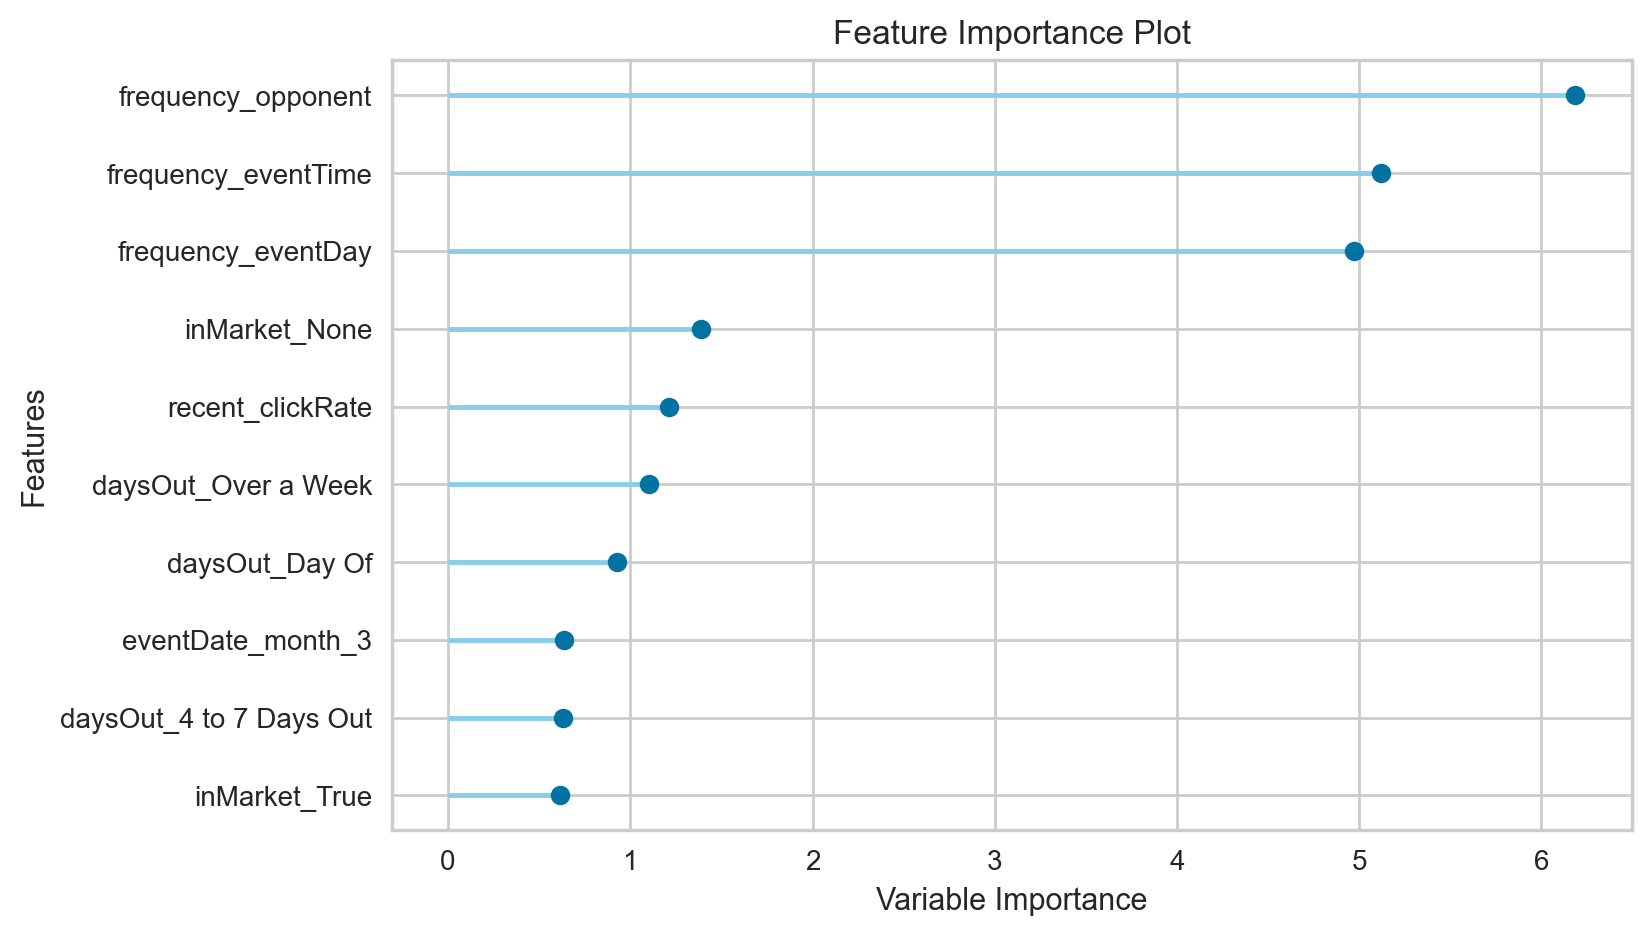

In [15]:
plot_model(best_model, plot='feature')

### This confusion matrix helps understand where the model guessed correctly or incorrectly based on the evaluation data:

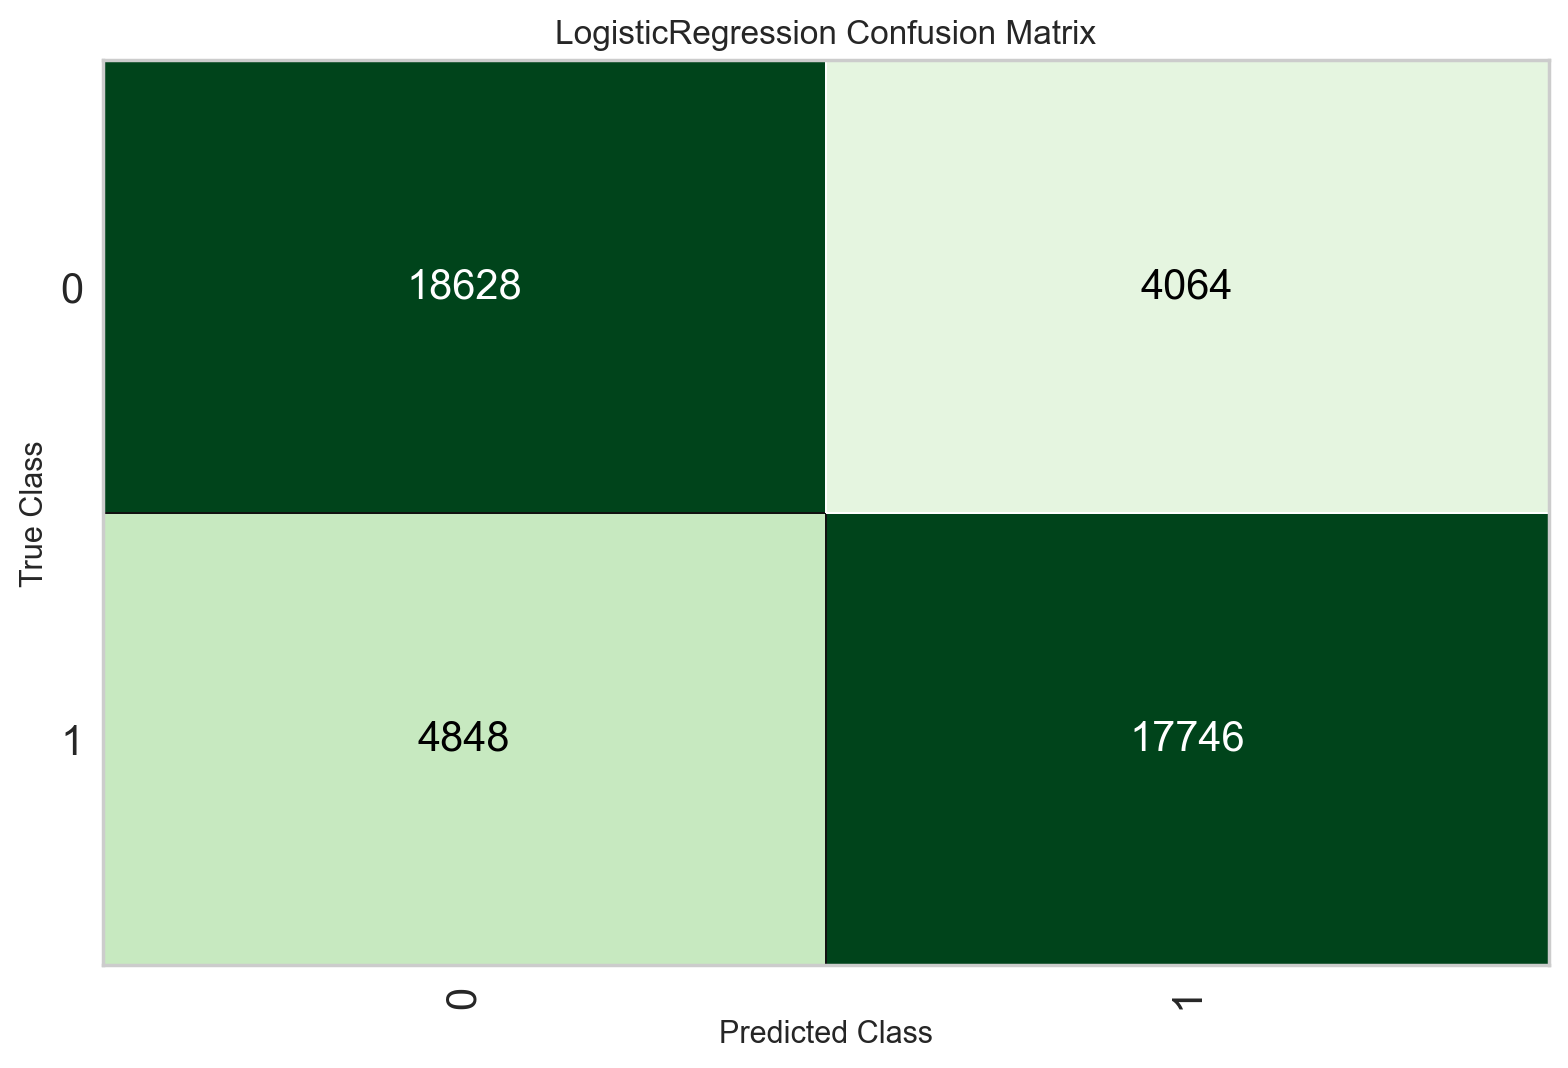

In [16]:
plot_model(best_model, plot='confusion_matrix')

### The AUC curve tells how much the model is capable of distinguishing between classes. The higher the curve, the better the model is at distiguishing classes:

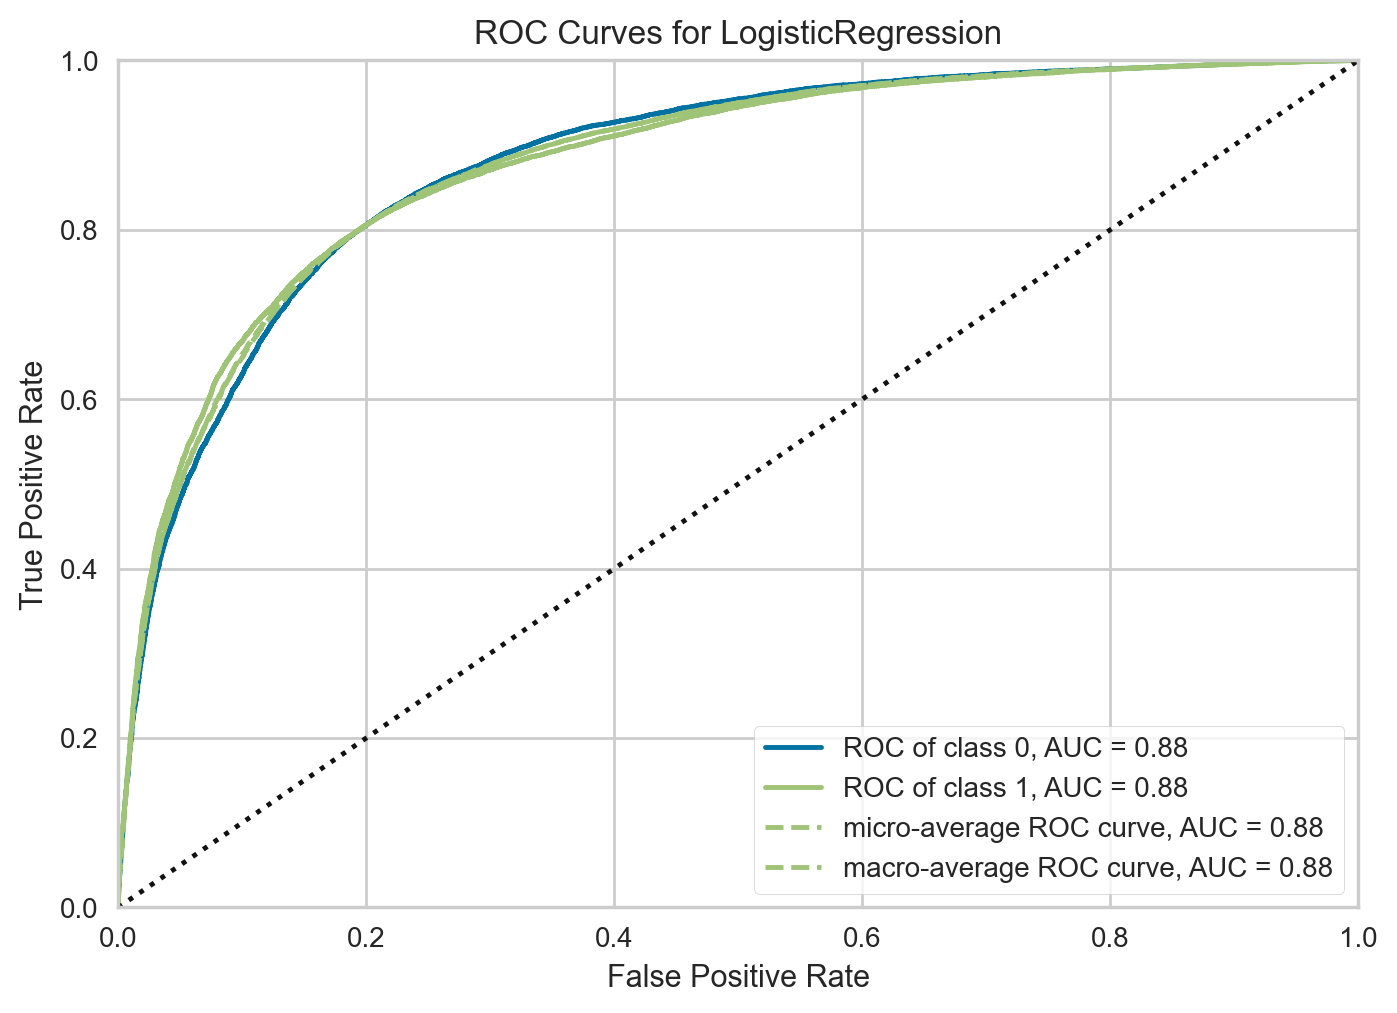

In [17]:
plot_model(best_model, plot='auc')

### Let's load up some real events from previous events to see how the model scores the data:

In [30]:
cursor = CNXN.cursor()

query = """
    SELECT
        daysOut,
        dimCustomerMasterId,
        eventDate,
        events_purchased,
        frequency_opponent,
        frequency_eventDay,
        frequency_eventTime,
        inMarket,
        distanceToVenue,
        recent_openRate,
        recent_clickRate,
        tenure
    FROM 
        DataScience.yankees.event_propensity_scoring_20190330
"""
    
df_inference = pd.read_sql(query, CNXN)
    
CNXN.commit()
cursor.close()

In [19]:
df_inference.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1648764 entries, 0 to 1648763
Data columns (total 12 columns):
 #   Column               Non-Null Count    Dtype         
---  ------               --------------    -----         
 0   daysOut              1648764 non-null  object        
 1   dimCustomerMasterId  1648764 non-null  int64         
 2   eventDate            1648764 non-null  datetime64[ns]
 3   events_purchased     1648764 non-null  float64       
 4   frequency_opponent   1648764 non-null  float64       
 5   frequency_eventDay   1647368 non-null  float64       
 6   frequency_eventTime  1648764 non-null  float64       
 7   inMarket             1406432 non-null  object        
 8   distanceToVenue      1406432 non-null  float64       
 9   recent_openRate      415456 non-null   float64       
 10  recent_clickRate     415456 non-null   float64       
 11  tenure               1648764 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
me

In [31]:
df_inference.eventDate.value_counts()

2019-03-30    1648764
Name: eventDate, dtype: int64

In [40]:
df_inference.to_csv("asdf.csv")

### Let's run the previous scores through the model for predictions:

In [32]:
df_scores = predict_model(best_model, data=df_inference, raw_score=True)
df_scores.head()

,daysOut,dimCustomerMasterId,eventDate,events_purchased,frequency_opponent,frequency_eventDay,frequency_eventTime,inMarket,distanceToVenue,recent_openRate,recent_clickRate,tenure,Label,Score_0,Score_1
0,Day Of,1671914,2019-03-30,1.0,0.0,0.0,0.022222,True,31.58,NaN,NaN,599,0,0.9103,0.0897
1,1 to 3 Days Out,1671914,2019-03-30,1.0,0.0,0.0,0.022222,True,31.58,NaN,NaN,599,0,0.8783,0.1217
2,4 to 7 Days Out,1671914,2019-03-30,1.0,0.0,0.0,0.022222,True,31.58,NaN,NaN,599,0,0.8830,0.1170
3,Over a Week,1671914,2019-03-30,1.0,0.0,0.0,0.022222,True,31.58,NaN,NaN,599,0,0.5724,0.4276
4,Day Of,1732044,2019-03-30,2.0,0.0,0.0,0.000000,True,18.70,0.0,0.0,601,0,0.9256,0.0744


### Included are some metrics on did and did_not purchase:

In [34]:
did_purchase = df_scores["Label"].value_counts()[1]
did_not_purchase = df_scores["Label"].value_counts()[0]
total_rows = df_scores["Label"].count()
purchase_percentage = round((did_purchase / total_rows), 4) * 100

print("Would purchase:", did_purchase)
print("Would not purchase:", did_not_purchase)
print("Purchase percentage:", purchase_percentage)

Would purchase: 170165
Would not purchase: 1478599
Purchase percentage: 10.32


In [36]:
df_inference_2 = helpers.get_event_propensity_scoring_dataset(
    cluster="prod-app",
    database="stlryankees",
    lkupclientid="53",
    game_date="2019-03-30"
)

df_inference_2.shape

Authorized as AROASQ4JELIXYLYV6P4UV:rkazmerik@stellaralgo.com


(3218440, 12)

In [37]:
df_scores_2 = predict_model(best_model, data=df_inference_2, raw_score=True)
df_scores_2.shape

In [39]:
did_purchase = df_scores_2["Label"].value_counts()[1]
did_not_purchase = df_scores_2["Label"].value_counts()[0]
total_rows = df_scores_2["Label"].count()
purchase_percentage = round((did_purchase / total_rows), 4) * 100

print("Would purchase:", did_purchase)
print("Would not purchase:", did_not_purchase)
print("Purchase percentage:", purchase_percentage)

Would purchase: 1702050
Would not purchase: 1516390
Purchase percentage: 52.88


### Here we can see the distribution of fans who did and did not purchase : Score_0 = Did Not Purchase, Score_1 = Did Purchase

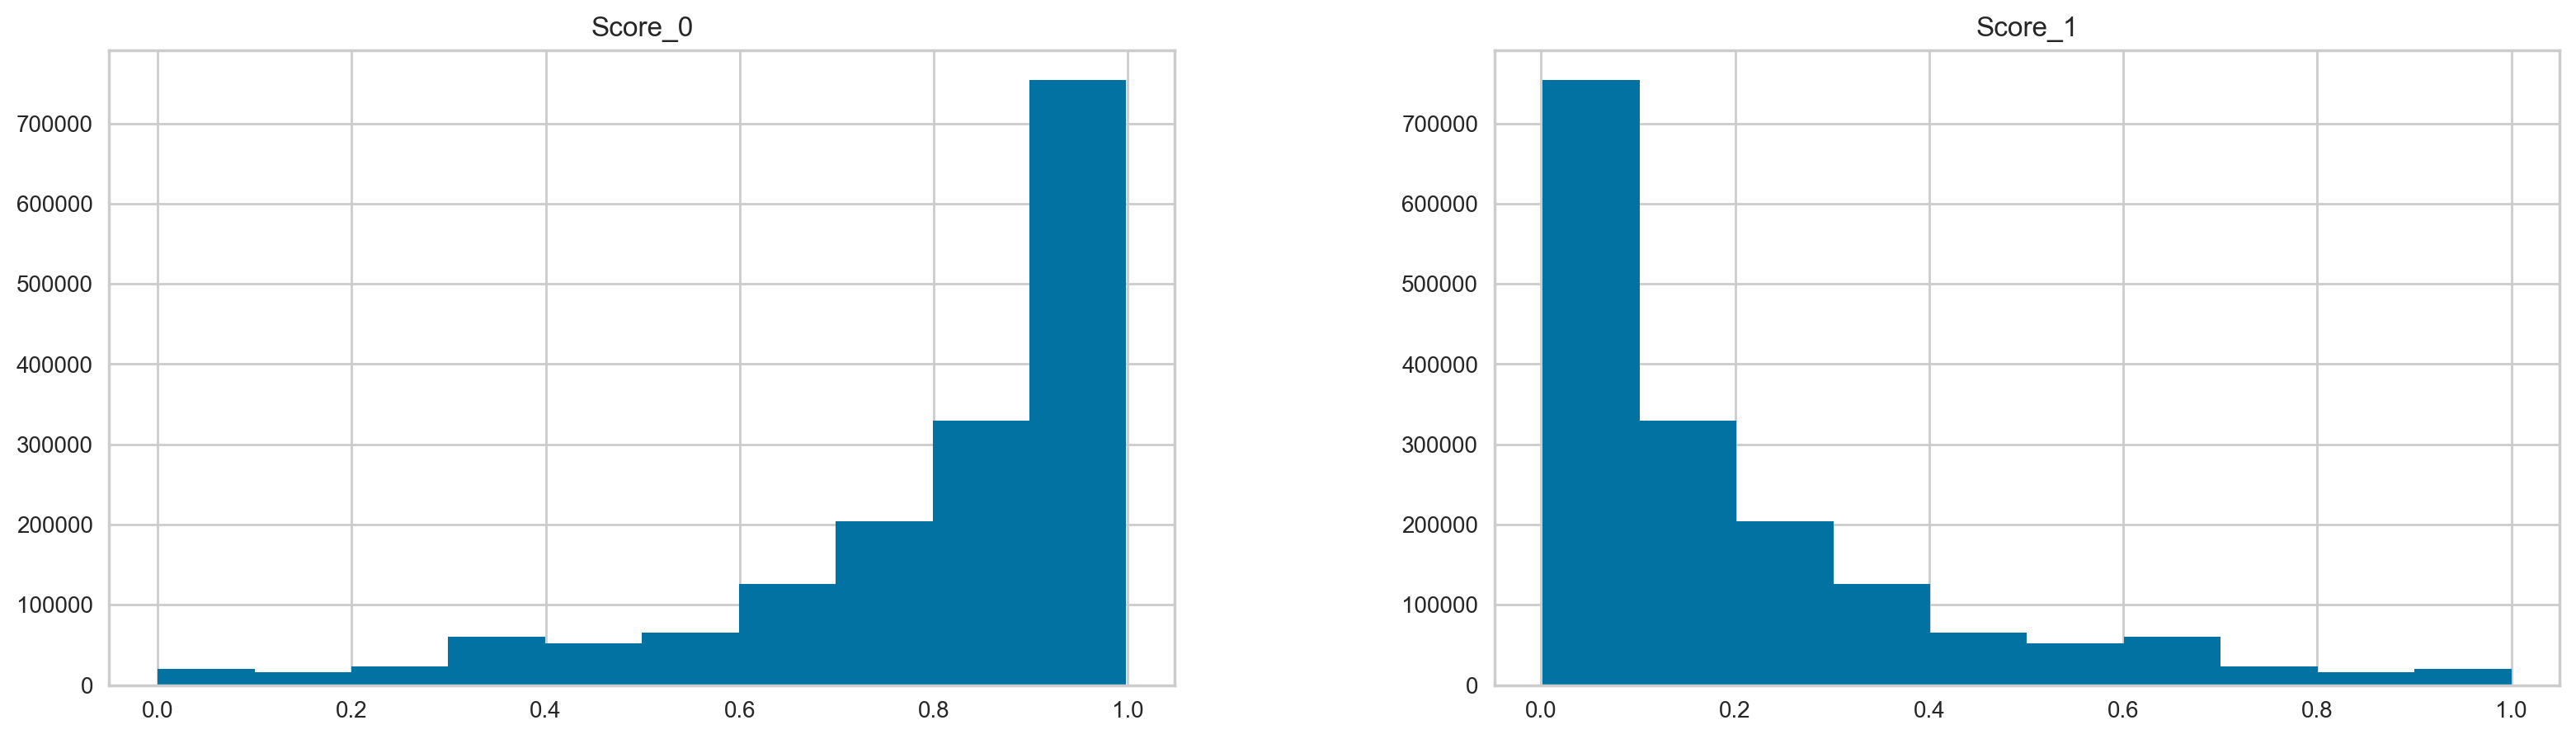

In [24]:
df_scoring.hist(column=['Score_0', 'Score_1'], figsize=(30,5), layout=(1,3));

In [25]:
# scoring_list = df_scoring.to_dict('records')

In [26]:
# max_dict = {}
# for record in scoring_list:
#     if record['dimCustomerMasterId'] not in max_dict:
#         max_dict[record['dimCustomerMasterId']] = 0
    
#     if record['Score_1'] > max_dict[record['dimCustomerMasterId']]:
#         max_dict[record['dimCustomerMasterId']] = record['Score_1']

In [27]:
#max_scores = [{'id': k, 'score': v} for k, v in max_dict.items()]
#max_scores.sort(key = lambda v: -v["score"])

#df_max_scores = pd.DataFrame(max_scores)
#df_max_scores.to_csv('yankees_scoring_test.csv')

In [ ]:
#df_max_scores.head()

In [ ]:
#df1 = df_scoring.loc[df_scoring.groupby('dimCustomerMasterId', sort=False)['Score_1'].idxmax()]

In [ ]:
#df1 = df1.sort_values(by='Score_1', ascending=False).reset_index()

In [ ]:
#df1 = df1.filter(['dimCustomerMasterId','Score_1'], axis=1)

In [ ]:
#df1.head()

## Observations
Here you can talk about next steps, did the experiment work? If yes, what to do next? If no, why?

In [ ]:
lkupclientid = 53 # Yankees

cursor = CNXN.cursor()

storedProc = (f"""Exec [stlrYankees].[ds].[getPropensityEventScoring] {lkupclientid}""")

df = pd.read_sql(storedProc, CNXN)

# apply some data transformations
df["year"] = pd.to_numeric(df["year"]) 

CNXN.commit()
cursor.close()

df.shape